# Stochastic Differential Equations: A Practical Tutorial

This tutorial demonstrates how to use our Foundation Inference Model (FIM) to estimate drift and diffusion functions from stochastic differential equation (SDE) data. This page provides a comprehensive introduction to using our trained SDE model with real data examples.

## Introduction

Stochastic Differential Equations are fundamental mathematical models used to describe systems that evolve over time under the influence of both deterministic forces (drift) and random noise (diffusion). These equations take the form:

```{math}
dx = f(x)dt + G(x)dW(t)
```

where:
- $f(x)$ is the **drift function** representing deterministic evolution
- $G(x)dW(t)$ is the **diffusion term** representing stochastic perturbations
- $W(t)$ is a Wiener process (Brownian motion)

Our model learns to estimate both $f$ and $G$ directly from observed trajectory data in a zero-shot manner, without requiring prior knowledge of the underlying system dynamics.

Let"s start by loading the necessary libraries and the pre-trained model.

In [1]:
from fim.models.sde import FIMSDE
from fim.sampling.sde_path_samplers import *
from datasets import load_dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the pre-trained SDE model
model = FIMSDE.from_pretrained("FIM4Science/fim-sde")
model.eval()

print(f"Model supports up to {model.config.max_dimension}D systems")

Model supports up to 3D systems


:::{note}
For GPU acceleration, you can move both the model and data tensors to your GPU device using `model.to(device)` and `tensor.to(device)` respectively.
:::

## Example 1: Double Well Potential

Let's start with a classic example in stochastic dynamics - the double well potential. This system exhibits bistable behavior where particles can transition between two stable states due to noise.

In [2]:
# Load the double well dataset
double_well_data = load_dataset("FIM4Science/sde-tutorial-double_well", download_mode="force_redownload")
data_sample = double_well_data["train"][0]  # Get first sample

print("Dataset structure:")
for key, value in data_sample.items():
    if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
        shape = f"({len(value)}, {len(value[0])}, ...)"
    else:
        shape = f"({len(value)})"
    print(f"  {key}: {shape}")

data/train-00000-of-00001.parquet:   0%|          | 0.00/208k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5 [00:00<?, ? examples/s]

Dataset structure:
  observations: (1, 5000, ...)
  locations: (1024, 1, ...)
  initial_states: (5, 1, ...)


In [3]:
# Prepare the data for the model
def prepare_sde_data(data_sample, num_paths=5, dt=0.002):
    """
    Convert dataset sample to model input format with custom time spacing
    """
    # Extract trajectory data
    trajectories = torch.tensor(data_sample["observations"][:num_paths], dtype=torch.float32)
    
    # Create evenly spaced times with specified dt
    num_timesteps = trajectories.shape[1]
    time_end = (num_timesteps - 1) * dt
    times_1d = torch.linspace(0, time_end, num_timesteps, dtype=torch.float32)
    
    # Times should be shared across all paths: [1, num_timesteps]
    # Then add batch and feature dimensions: [1, 1, num_timesteps, 1]
    times = times_1d.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
    
    # Reshape for model input: [batch_size, num_paths, time_steps, dimensions]
    batch_size = 1
    trajectories = trajectories.unsqueeze(0)  # Add batch dimension
    
    # Create locations grid for evaluation
    x_min, x_max = trajectories.min(), trajectories.max()
    locations = torch.linspace(x_min - 0.5, x_max + 0.5, 50).unsqueeze(0).unsqueeze(-1)
    locations = locations  # Add batch dimension
    
    print(f"Using dt = {dt}")
    print(f"Time range: 0 to {time_end:.3f}")
    print(f"Number of timesteps: {num_timesteps}")
    print(f"Times tensor shape: {times.shape}")
    print(f"Trajectories tensor shape: {trajectories.shape}")
    print(f"Locations tensor shape: {locations.shape}")
    
    return {
        "obs_values": trajectories,
        "obs_times": times,
        "locations": locations
    }

# Prepare double well data
dw_input = prepare_sde_data(data_sample, num_paths=3, dt=0.002)

print(f"Prepared data shapes:")
print(f"  Trajectories: {dw_input['obs_values'].shape}")
print(f"  Times: {dw_input['obs_times'].shape}")
print(f"  Locations: {dw_input['locations'].shape}")

Using dt = 0.002
Time range: 0 to 9.998
Number of timesteps: 5000
Times tensor shape: torch.Size([1, 1, 5000, 1])
Trajectories tensor shape: torch.Size([1, 1, 5000, 1])
Locations tensor shape: torch.Size([1, 50, 1])
Prepared data shapes:
  Trajectories: torch.Size([1, 1, 5000, 1])
  Times: torch.Size([1, 1, 5000, 1])
  Locations: torch.Size([1, 50, 1])


In [4]:
# Run the model to estimate drift and diffusion
with torch.no_grad():
    results = model(dw_input, training=False)

estimated_concepts = results
print(f"Drift shape: {estimated_concepts.drift.shape}")
print(f"Diffusion shape: {estimated_concepts.diffusion.shape}")
print(f"Concepts normalized: {estimated_concepts.normalized}")

Drift shape: torch.Size([1, 50, 3])
Diffusion shape: torch.Size([1, 50, 3])
Concepts normalized: False


## Sampling paths
The FIM-SDE model can also sample trajectories from the estimated process behind the observed data. Let's try this and see if they behave as we would expect,
e.g. jumping between the two wells and not escaping them.

In [5]:
# Create initial states from the first timestep of observed trajectories
# Shape should be [B, I, D] where B=batch, I=initial_states, D=dimensions
initial_states = (dw_input["obs_values"][:, 0, 0:1, :]).expand(1,5,1)  # [1, 5, 1] - first timestep, all dimensions

# Create time grid from observed times
# Shape should be [B, P, T, 1] where P=paths, T=timesteps
time_grid = dw_input["obs_times"]  # [1, 1, 5000, 1] Can be changed to  w_input["locations"] or other coarser grids to speed up sampling
# Expand to match number of paths we want to sample
time_grid = time_grid.expand(1, 5, -1, -1)  # [1, 5, 5000, 1]

# Create mask (all True since we want to sample at all time points)
# Shape should be [B, P, T, 1]
mask = torch.ones_like(time_grid, dtype=torch.bool)  # [1, 5, 5000, 1]

print(f"Initial states shape: {initial_states.shape}")
print(f"Time grid shape: {time_grid.shape}")
print(f"Mask shape: {mask.shape}")


Initial states shape: torch.Size([1, 5, 1])
Time grid shape: torch.Size([1, 5, 5000, 1])
Mask shape: torch.Size([1, 5, 5000, 1])


In [6]:
# Sample paths using the masked grid function
with torch.no_grad():
    sampled_paths = fimsde_sample_paths_on_masked_grid(
        model=model,
        data=dw_input,
        grid=time_grid,
        mask=mask,
        initial_states=initial_states,
        solver_granularity=10,
        silent=True
    )

print(f"Sampled paths shape: {sampled_paths[0].shape}")
print(f"Sampled time grid shape: {sampled_paths[1].shape}")

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original trajectories
original_trajectories = dw_input["obs_values"][0]  # [3, 5000, 1]
original_times = dw_input["obs_times"][0, 0, :, 0]  # [5000]

axes[0].set_title("Original Trajectories")
for i in range(original_trajectories.shape[0]):
    axes[0].plot(original_times, original_trajectories[i, :, 0], alpha=0.7, linewidth=1.5,
                label=f'Original {i+1}')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("X(t)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Sampled trajectories
axes[1].set_title("Sampled Trajectories")
sampled_times = sampled_paths[1][0, 0, :, 0]  # [5000]
for i in range(5):
    axes[1].plot(sampled_times, sampled_paths[0][0, i, :, 0], alpha=0.7, linewidth=1.5,
                label=f"Sampled {i+1}",color="gray")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("X(t)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
sampled_paths[0].shape, sampled_paths[1].shape

(torch.Size([1, 5, 5000, 1]), torch.Size([1, 5, 5000, 1]))

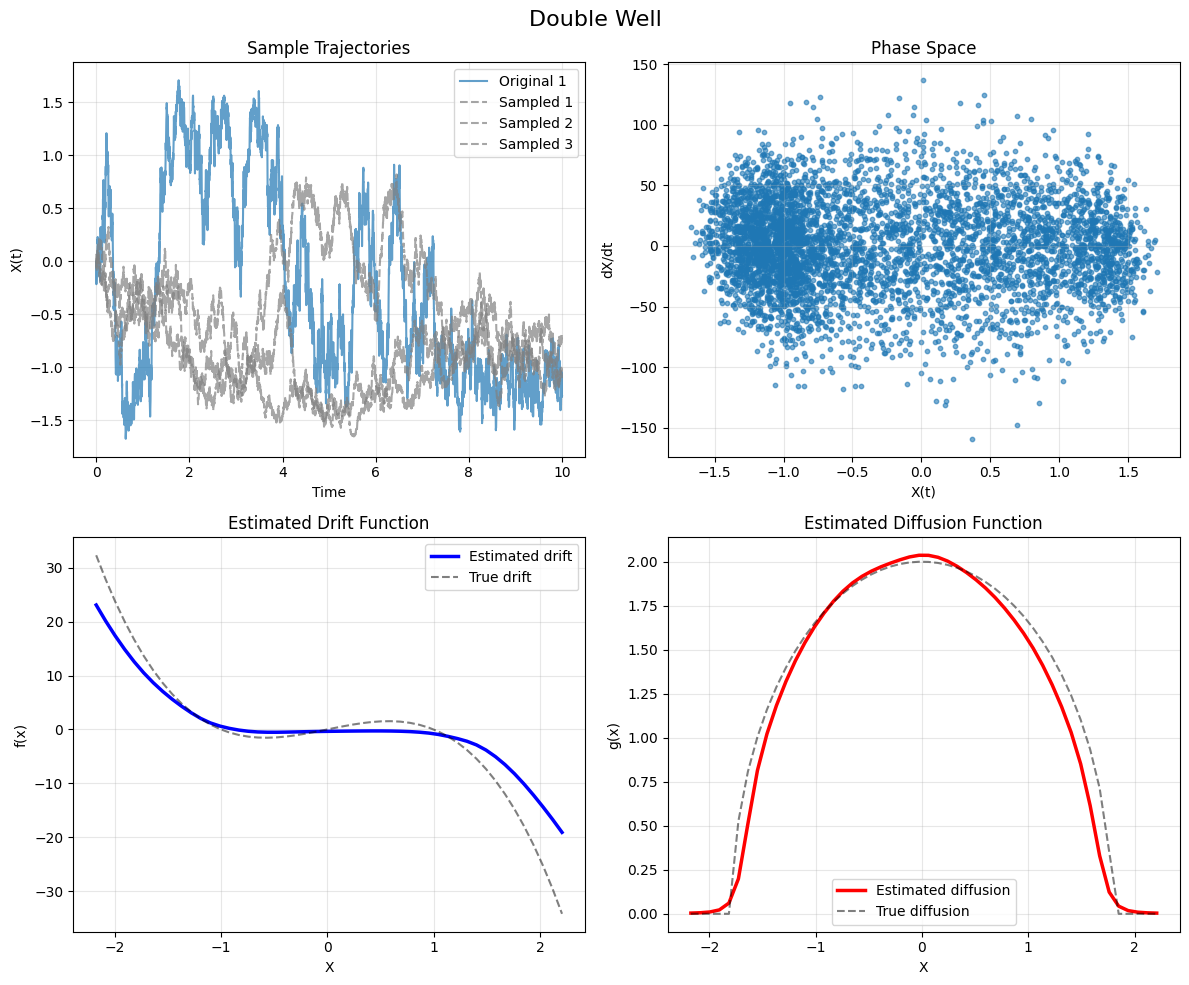

In [ ]:
# Visualize the results
def plot_sde_results(input_data, estimated_concepts, sampled_paths, title):
    """
    Plot trajectories, estimated drift, and diffusion functions
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)
    
    # Extract data
    trajectories = input_data["obs_values"][0]  # Remove batch dimension
    times = input_data["obs_times"][0, 0, :, 0]  # Shared times: [num_timesteps]
    locations = estimated_concepts.locations[0, :, 0].cpu()  # Remove batch dimension
    drift = estimated_concepts.drift[0, :, 0].cpu()
    diffusion = estimated_concepts.diffusion[0, :, 0].cpu()
    
    # Plot trajectories
    axes[0, 0].set_title("Sample Trajectories")
    # Original trajectories
    for i in range(min(3, trajectories.shape[0])):
        axes[0, 0].plot(times, trajectories[i, :, 0], alpha=0.7, linewidth=1.5,
                       label=f'Original {i+1}')
    
    # Sampled trajectories (if available)
    if sampled_paths is not None:
        sampled_times = sampled_paths[1][0, 0, :, 0]  # Time grid from sampled paths
        for i in range(3):
            axes[0, 1].plot(sampled_times, sampled_paths[0][0, i, :, 0], 
                           alpha=0.7, linewidth=1.5, linestyle='--',color="gray")
    axes[0, 1].set_xlabel("Time")
    axes[0, 1].set_ylabel("X(t)")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    
    # Plot estimated drift
    axes[1, 0].set_title("Estimated Drift Function")
    axes[1, 0].plot(locations, drift, "b-", linewidth=2.5, label="Estimated drift")
    axes[1, 0].plot(locations, 4*(locations-locations**3), color="k", linestyle="--", alpha=0.5, label="True drift")
    axes[1, 0].set_xlabel("X")
    axes[1, 0].set_ylabel("f(x)")
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Plot estimated diffusion
    axes[1, 1].set_title("Estimated Diffusion Function")
    axes[1, 1].plot(locations, diffusion, "r-", linewidth=2.5, label="Estimated diffusion")
    axes[1, 1].plot(locations, torch.sqrt(torch.max(4-1.25*locations**2, torch.tensor(0.0))), 
                   color="k", linestyle="--", alpha=0.5, label="True diffusion")
    axes[1, 1].set_xlabel("X")
    axes[1, 1].set_ylabel("g(x)")
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    plt.tight_layout()
    return fig

# Create visualization
fig = plot_sde_results(dw_input, estimated_concepts, sampled_paths=sampled_paths, title="Double Well")
plt.show()

## Example 2: Duffing oscillator

In [ ]:
duffing_data = load_dataset("FIM4Science/sde-tutorial-duffing", download_mode="force_redownload")
duffing_sample = duffing_data["train"][0]

def prepare_2d_sde_data(data_sample, num_paths=3, dt=0.002):
    """
    Prepare 2D system data (like Duffing oscillator) with custom time spacing
    """
    trajectories = torch.tensor(data_sample["observations"][:num_paths], dtype=torch.float32)
    
    # Create evenly spaced times with specified dt
    num_timesteps = trajectories.shape[1]
    time_end = (num_timesteps - 1) * dt
    times_1d = torch.linspace(0, time_end, num_timesteps, dtype=torch.float32)
    
    # Times should be shared across all paths: [1, num_timesteps]
    # Then add batch and feature dimensions: [1, 1, num_timesteps, 1]
    times = times_1d.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
    
    # Reshape for model input: [batch_size, num_paths, time_steps, dimensions]
    batch_size = 1
    trajectories = trajectories.unsqueeze(0)  # Add batch dimension
    
    # Create 2D locations grid for evaluation
    x_min, x_max = trajectories[:, :, :, 0].min(), trajectories[:, :, :, 0].max()
    y_min, y_max = trajectories[:, :, :, 1].min(), trajectories[:, :, :, 1].max()
    
    x_grid = torch.linspace(x_min - 0.5, x_max + 0.5, 25)
    y_grid = torch.linspace(y_min - 0.5, y_max + 0.5, 25)
    
    X, Y = torch.meshgrid(x_grid, y_grid, indexing="ij")
    locations = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    locations = locations.unsqueeze(0)  # Add batch dimension
    
    print(f"Using dt = {dt}")
    print(f"Time range: 0 to {time_end:.3f}")
    print(f"Number of timesteps: {num_timesteps}")
    print(f"Times tensor shape: {times.shape}")
    print(f"Trajectories tensor shape: {trajectories.shape}")
    print(f"Locations tensor shape: {locations.shape}")
    
    return {
        "obs_values": trajectories,
        "obs_times": times,
        "locations": locations
    }

data/train-00000-of-00001.parquet:   0%|          | 0.00/405k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
# Run the model on Duffing oscillator
duffing_input = prepare_2d_sde_data(duffing_sample, num_paths=3, dt=0.002)
with torch.no_grad():
    duffing_results = model(duffing_input, training=False)

Using dt = 0.002
Time range: 0 to 9.998
Number of timesteps: 5000
Times tensor shape: torch.Size([1, 1, 5000, 1])
Trajectories tensor shape: torch.Size([1, 1, 5000, 2])
Locations tensor shape: torch.Size([1, 625, 2])


We can again sample some paths:

In [ ]:
initial_states = (duffing_input["obs_values"][:, 0, 0:1, :]).expand(1,5,2)
with torch.no_grad():
    sampled_paths_duffing = fimsde_sample_paths_on_masked_grid(
        model=model,
        data=duffing_input,
        grid=time_grid,
        mask=mask,
        initial_states=initial_states,
        solver_granularity=10,
        silent=True
)

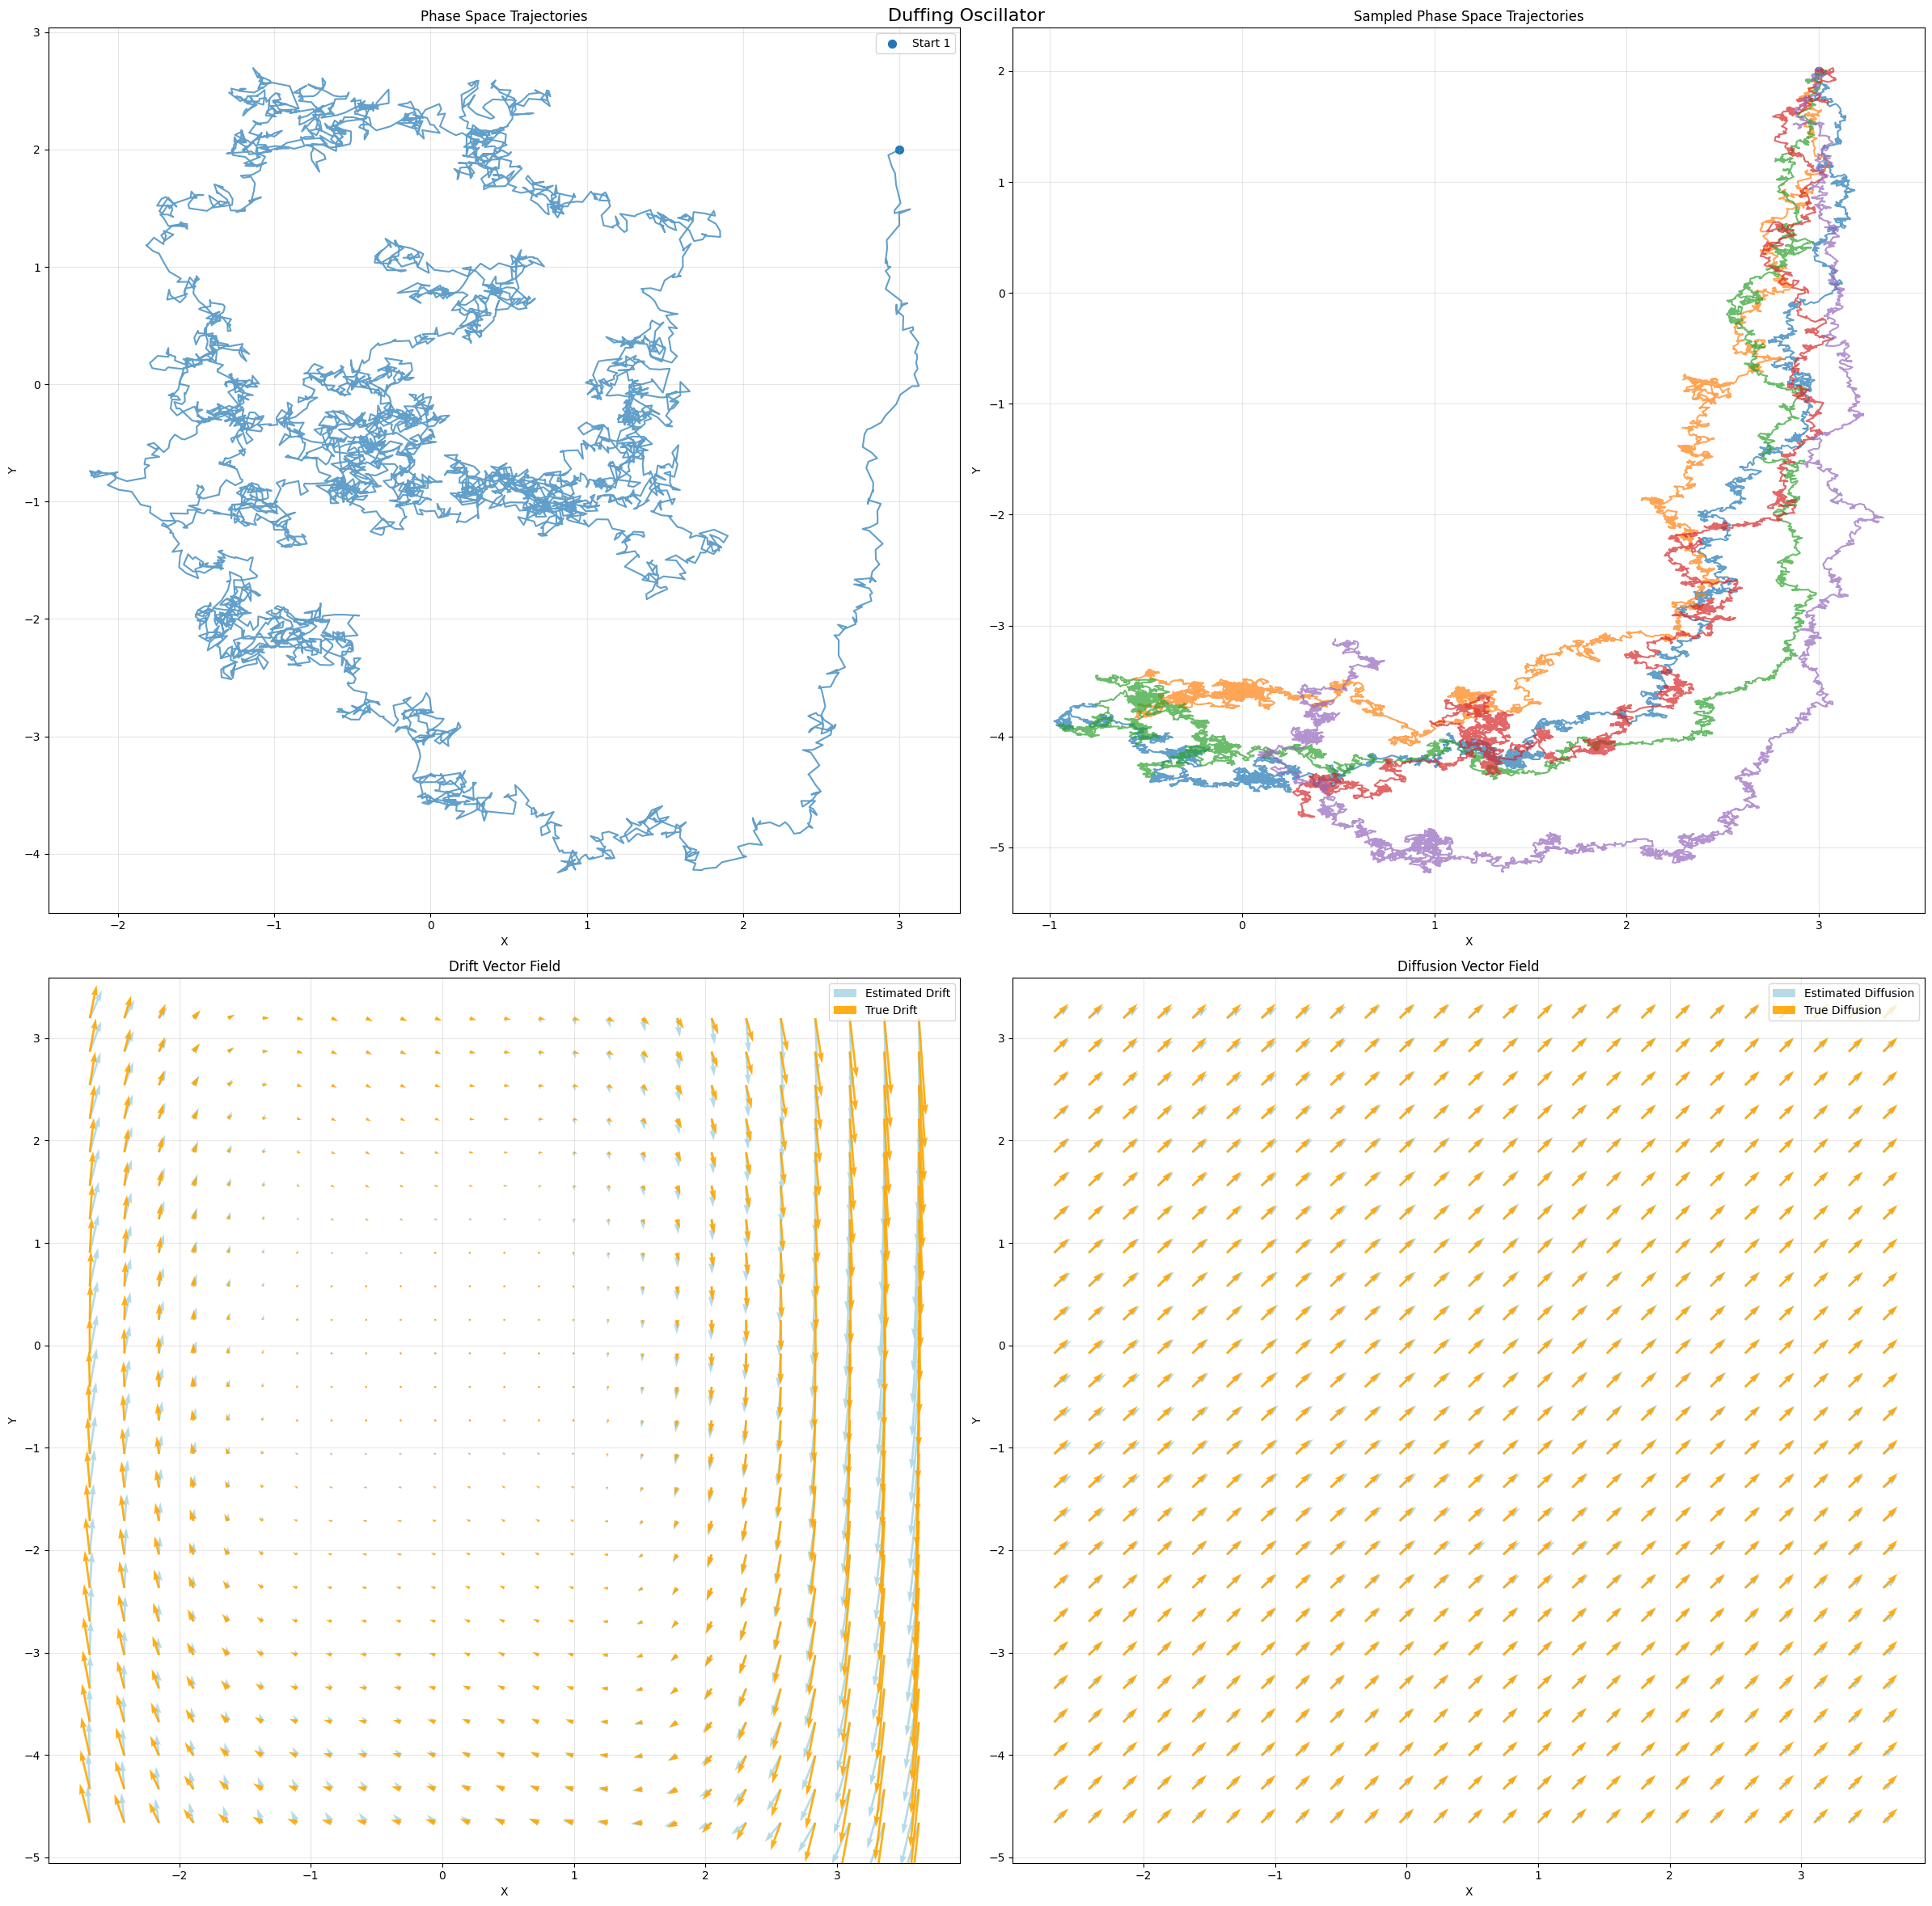

In [ ]:
# Visualize 2D system results
def plot_2d_sde_results(input_data, estimated_concepts, title="2D SDE Analysis",sampled_paths_duffing=None):
    """
    Plot 2D system trajectories and vector fields
    """
    fig, axes = plt.subplots(2, 2, figsize=(24, 24))
    fig.suptitle(title, fontsize=16)
    
    # Extract data
    trajectories = input_data["obs_values"][0]  # Remove batch dimension
    locations = estimated_concepts.locations[0].cpu()  # Remove batch dimension
    drift = estimated_concepts.drift[0].cpu()
    diffusion = estimated_concepts.diffusion[0].cpu()
    
    # Reshape for vector field plotting
    grid_size = int(np.sqrt(locations.shape[0]))
    X = locations[:, 0].reshape(grid_size, grid_size)
    Y = locations[:, 1].reshape(grid_size, grid_size)
    U = drift[:, 0].reshape(grid_size, grid_size)
    U_true = Y
    V = drift[:, 1].reshape(grid_size, grid_size)
    V_true = -(X**3-X+0.35*Y)

    # Plot trajectories
    axes[0, 0].set_title("Phase Space Trajectories")
    for i in range(trajectories.shape[0]):
        axes[0, 0].plot(trajectories[i, :, 0], trajectories[i, :, 1], alpha=0.7, linewidth=1.5)
        axes[0, 0].scatter(trajectories[i, 0, 0], trajectories[i, 0, 1], s=50, marker="o", 
                          label=f"Start {i+1}" if i < 3 else "")
    axes[0, 0].set_xlabel("X")
    axes[0, 0].set_ylabel("Y")
    axes[0, 0].grid(True, alpha=0.3)
    if trajectories.shape[0] <= 3:
        axes[0, 0].legend()

    axes[0, 1].set_title("Sampled Phase Space Trajectories")
    for i in range(5):
        axes[0, 1].plot(sampled_paths_duffing[0][0,i, :, 0], sampled_paths_duffing[0][0,i, :, 1], alpha=0.7, linewidth=1.5)
        axes[0, 1].scatter(sampled_paths_duffing[0][0,i, 0, 0], sampled_paths_duffing[0][0,i, 0, 1], s=50, marker="o")
    axes[0, 1].set_xlabel("X")
    axes[0, 1].set_ylabel("Y")
    axes[0, 1].grid(True, alpha=0.3)


    # Plot drift vector field
    axes[1, 0].set_title("Drift Vector Field")
    axes[1, 0].quiver(X, Y, U, V, alpha=0.9, label="Estimated Drift",color="lightblue")
    axes[1, 0].quiver(X, Y, U_true, V_true, alpha=0.9, label="True Drift",color="orange")
    # Overlay trajectories
    axes[1, 0].set_xlabel("X")
    axes[1, 0].set_ylabel("Y")
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()


    U = diffusion[:, 0].reshape(grid_size, grid_size)
    U_true = torch.ones_like(U)
    V = diffusion[:, 1].reshape(grid_size, grid_size)
    V_true = torch.ones_like(V)

    axes[1, 1].set_title("Diffusion Vector Field")
    axes[1, 1].quiver(X, Y, U, V, alpha=0.9, label="Estimated Diffusion",color="lightblue")
    axes[1, 1].quiver(X, Y, U_true, V_true, alpha=0.9, label="True Diffusion",color="orange")
    # Overlay trajectories
    axes[1, 1].set_xlabel("X")
    axes[1, 1].set_ylabel("Y")
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

    plt.tight_layout()
    return fig

# Create visualization for Duffing oscillator
fig = plot_2d_sde_results(duffing_input, duffing_results, "Duffing Oscillator",sampled_paths_duffing)
plt.show()